<a href="https://colab.research.google.com/github/shachimaurya23/Learning/blob/main/PyTorch/PyTorch_Learning_CNN_FMNIST_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(42)

In [5]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:',device)

device: cuda


In [6]:
df=pd.read_csv('fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df.shape

(60000, 785)

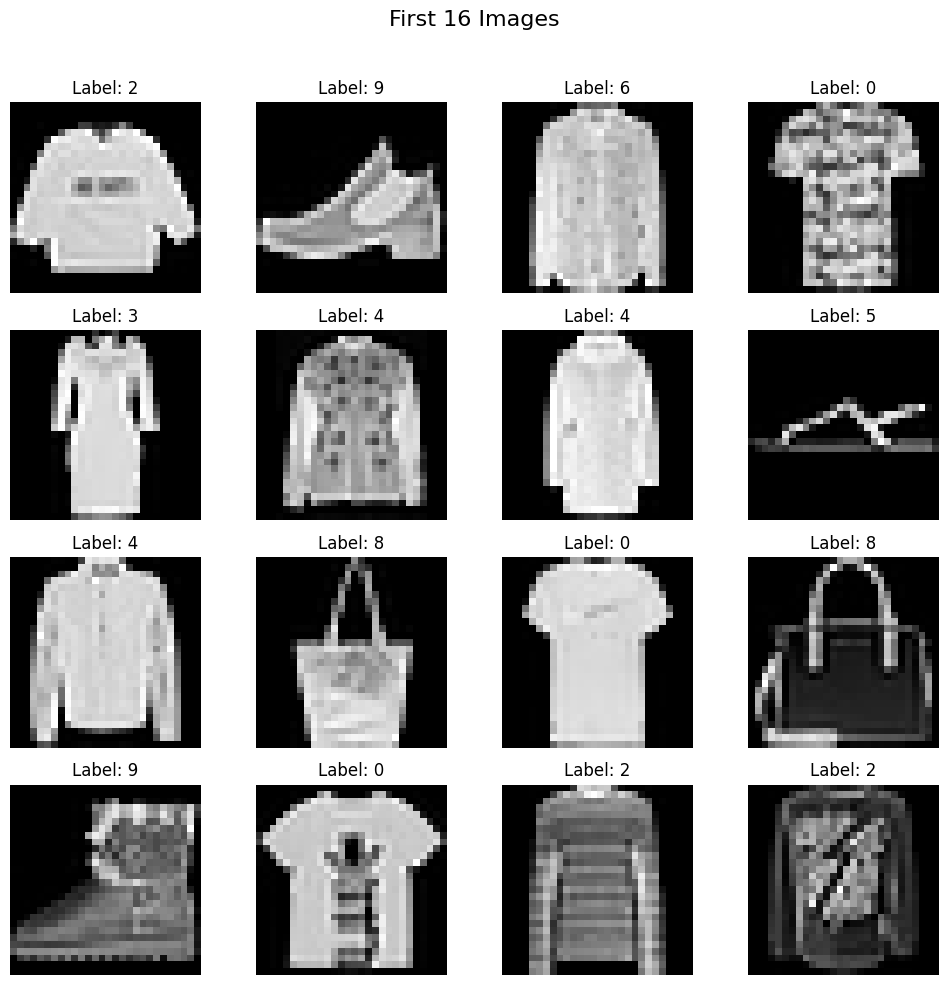

In [9]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img,cmap='grey')
    ax.axis('off')
    ax.set_title(f"Label: {df.iloc[i, 0]}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [10]:
#train test split
X=df.iloc[:,1:].values
y=df.iloc[:,0].values

In [11]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [12]:
#normalize
X_train=X_train/255.0
X_test=X_test/255.0

In [16]:
class CustomDataset(Dataset):
  def __init__(self,features,labels):
    self.features=torch.tensor(features,dtype=torch.float32).reshape(-1,1,28,28) #reshape 1d to 2d array 1-> channel, 28*28->image size 784 -1-> batch size placeholder
    self.labels=torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self,idx):
    return self.features[idx],self.labels[idx]

In [17]:
train_dataset=CustomDataset(X_train,y_train)
test_dataset=CustomDataset(X_test,y_test)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [22]:
class myCNN(nn.Module):
  def __init__(self,features):
    super().__init__()

    self.features=nn.Sequential(
        nn.Conv2d(features,32,kernel_size=3,padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2,stride=2),

        nn.Conv2d(32,64,kernel_size=3,padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2,stride=2))

    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*7*7,128),
        nn.ReLU(),
        nn.Dropout(p=0.4),

        nn.Linear(128,64),
        nn.ReLU(),
        nn.Dropout(p=0.4),

        nn.Linear(64,10)
    )
  def forward(self,x):
    x=self.features(x)
    x=self.classifier(x)
    return x



In [20]:
learning_rate=0.01
epochs=100

In [23]:
model=myCNN(1)
model.to(device)

loss_function=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)

In [25]:
#training loop
for epoch in range(epochs):
  total_epoch_loss=0
  for batch_features,batch_labels in train_loader:
    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)

    y_pred=model(batch_features) #forward pass
    loss=loss_function(y_pred,batch_labels)
    optimizer.zero_grad()
    loss.backward() # backward pass
    optimizer.step() #update weights

    total_epoch_loss+=loss.item()

  avg_loss=total_epoch_loss/len(train_loader)
  print(f'Epoch : {epoch+1}, Loss : {avg_loss}')


Epoch : 1, Loss : 0.6682833328743776
Epoch : 2, Loss : 0.3867432298163573
Epoch : 3, Loss : 0.32444419303288063
Epoch : 4, Loss : 0.2907682353258133
Epoch : 5, Loss : 0.26399966598053776
Epoch : 6, Loss : 0.24652865219737094
Epoch : 7, Loss : 0.2306274610981345
Epoch : 8, Loss : 0.21487142912422616
Epoch : 9, Loss : 0.2024088937876125
Epoch : 10, Loss : 0.19248113657782476
Epoch : 11, Loss : 0.1791415118140479
Epoch : 12, Loss : 0.16947951296530664
Epoch : 13, Loss : 0.15858761512798566
Epoch : 14, Loss : 0.1531229179976508
Epoch : 15, Loss : 0.1411478937738575
Epoch : 16, Loss : 0.13407255224697293
Epoch : 17, Loss : 0.12998814982843274
Epoch : 18, Loss : 0.12014068865931282
Epoch : 19, Loss : 0.11446130166000996
Epoch : 20, Loss : 0.1097982577875567
Epoch : 21, Loss : 0.10629868647595868
Epoch : 22, Loss : 0.101682230196738
Epoch : 23, Loss : 0.09306993451629145
Epoch : 24, Loss : 0.09136284657342669
Epoch : 25, Loss : 0.08823247987039698
Epoch : 26, Loss : 0.0806889268924715
Epoch :

In [26]:
model.eval()

myCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [27]:
#evaluate on test data

total=0
correct=0

with torch.no_grad():
  for batch_features,batch_labels in test_loader:
    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)
    y_pred=model(batch_features)
    _,predicted=torch.max(y_pred,1)
    total+=batch_labels.shape[0]
    correct+=(predicted==batch_labels).sum().item()
print(correct/total)

0.92225


In [28]:
#evaluate on train data

total=0
correct=0

with torch.no_grad():
  for batch_features,batch_labels in train_loader:
    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)
    y_pred=model(batch_features)
    _,predicted=torch.max(y_pred,1)
    total+=batch_labels.shape[0]
    correct+=(predicted==batch_labels).sum().item()
print(correct/total)

0.9998541666666667
